# Data Sources 

- 'data/Patch_Size_Data_Revisions.csv'

This csv file contains the the patch size data from the 26 patients included in Baker et al., Cell Reports, 2014 along with the age and diagnosis of each patient and the total number of crypts analysed. Whether the samples were fresh-frozen (instead of FFPE) is also recorded.

# Analysis

In [1]:
# Import relevant python modules

import numpy as np
import pandas as pd
from scipy.optimize import fsolve
from skimage.measure import label, regionprops
import matplotlib.pyplot as plt
import seaborn as sns


We shall define some functions to calculate the fission rate per crypt, apply both the original and revised corrections to the data and print the mean fission rates for the 3 disease groups (Normal, FAP and AFAP).

In [2]:
# Define functions

def patch_size_distribution(b, t, m):
    K_m = (1 - np.exp(-b * t))**m / (b*t*m)
    return K_m


def function_to_solve(b, mean_patch_size, t):
    # This function is a rearranged version of d(LL)/db which will
    # maximise the log-likelihood when set to zero

    func = mean_patch_size - (np.exp(b*t) - 1) / (b*t)

    return func

def wrapper_function(mean_patch_size, t):
    # A wrapper function to pass to fsolve (which can only accept 
    # functions that have a single parameter)

    return lambda b:  function_to_solve(b, mean_patch_size, t)

def error_on_estimate(b, t, patch_dist):
    # The standard error of a maximum likelihood estimate can be calculated 
    # from the Fisher Information, which in turn can be calculated from 
    # d^2(LL)/db^2.

    patch_size = patch_dist.index.astype(int).values
    sum_m = np.sum(patch_size * patch_dist)
    Npatches = np.sum(patch_dist)

    d2LL_db2 = Npatches/(b**2) + sum_m * (t**2) / (2 - 2*np.cosh(b*t))

    sd = 1 / np.sqrt(- d2LL_db2)

    return sd

def calculate_fission_rate(data):
    # This function calculates the fission rate per crypt for each patient 
    # from data in the form of a pandas array using the above wrapper function

    patch_data = data.loc[:, '1':'15']
    age = data.Ages
    patch = patch_data.columns.values.astype(int)
    
    b_rate = list()
    b_rate_error = list()
    b_initial = 0.01

    for index, t in enumerate(age):
        patch_dist = patch_data.loc[index, :]
        mean_patch_size = sum(patch * patch_dist) / sum(patch_dist)

        f_fission = wrapper_function(mean_patch_size, t)

        fission_rate = fsolve(f_fission, b_initial)[0]
        error = error_on_estimate(fission_rate, t, patch_dist)
        
        b_rate.append(fission_rate)
        b_rate_error.append(error)

    data['fission_rate'] = b_rate
    data['fission_rate_error'] = b_rate_error

    return data


def original_correction(data):
    # The original correction applied to data in Baker et al. (2014) 
    # in which singleton crypts are ignored
    data = data.copy()
    
    total = data.TotalCrypts
    number_of_neighbours = 4
    number_of_patches = np.sum(data.loc[:, '1':'15'], axis = 1)

    # Correct the data for spontaneous mutation of adjacent patches
    mutation_rate = number_of_patches/total

    data['2'] = (data['2'] - (mutation_rate)**2 * (number_of_neighbours / 2) * total)
    
    data.loc[data['2'] < 0, '2'] = 0
    data['1'] = 0

    return data

def revised_correction(data):
    # The revised correction in which we do not ignore the singleton crypts
    
    data = data.copy()
    
    total = data.TotalCrypts
    number_of_neighbours = 4
    number_of_patches = np.sum(data.loc[:, '1':'15'], axis = 1)

    # Correct the data for spontaneous mutation of adjacent patches
    mutation_rate = number_of_patches/total
    data['1'] = (data['1'] + 2 * (mutation_rate)**2 * (1-mutation_rate)**(2*number_of_neighbours-2)
                 * (number_of_neighbours / 2) * total)
    data['2'] = (data['2'] - (mutation_rate)**2 * (1-mutation_rate)**(2*number_of_neighbours-2)
                 * (number_of_neighbours / 2) * total)
    data.loc[data['2'] < 0, '2'] = 0

    return data

def print_mean_fission_rate(fission_data):
    # A function that prints the mean fission rate of data that has been 
    # passed to the calculate_fission_rate function
    disease = ['Normal', 'FAP', 'AFAP']
    
    for d in disease:
        average = np.mean(fission_data.loc[fission_data['Disease'] == d, 'fission_rate'])
        sd = np.std(fission_data.loc[fission_data['Disease'] == d, 'fission_rate'], ddof=1)
        print('The mean fission rate for {} is {:.2} ± {:.1}'.format(d, average, sd))



Firstly, we shall import the data from a csv file.

In [3]:
# Load original data from a csv file 
OriginalDataPath = 'data/Patch_Size_Data_Revisions.csv'
OriginalData = pd.read_csv(OriginalDataPath)

OriginalData


,PatientNumber,FreshFrozen,Disease,Ages,TotalCrypts,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,1,True,Normal,79,4919,228,71,23,6,3,2,1,0,0,0,0,0,0,0,0
1,2,True,Normal,60,3547,54,1,2,2,0,0,0,0,0,0,0,0,0,0,0
2,3,True,Normal,64,6958,86,6,1,0,0,0,0,0,0,0,0,0,0,0,0
3,4,True,FAP,67,6417,106,49,17,4,7,0,0,0,0,0,0,0,0,0,0
4,5,True,FAP,59,4095,40,15,13,8,8,2,0,0,0,0,0,0,0,0,0
5,6,True,FAP,39,3085,29,4,2,0,0,0,0,0,0,0,0,0,0,0,0
6,7,True,AFAP,64,11313,143,64,17,2,2,0,2,0,1,0,1,0,0,0,0
7,8,True,AFAP,65,11755,86,39,11,4,0,0,0,0,0,0,0,0,0,0,0
8,9,True,AFAP,61,4174,65,37,20,10,1,0,2,3,0,0,0,0,0,0,0
9,14,True,Normal,42,2702,20,6,0,1,0,1,0,0,0,0,0,0,0,0,0


We shall now apply the original correction to the original data included in the 2014 paper.

In [4]:
OriginalData_OriginalCorrections = original_correction(OriginalData)

OriginalData_OriginalCorrections_fission = calculate_fission_rate(OriginalData_OriginalCorrections)

round_dict = {key:1 for key in OriginalData.columns[5:] }

OriginalData_OriginalCorrections_fission.round(round_dict)

,PatientNumber,FreshFrozen,Disease,Ages,TotalCrypts,1,2,3,4,5,...,8,9,10,11,12,13,14,15,fission_rate,fission_rate_error
0,1,True,Normal,79,4919,0,25.6,23,6,3,...,0,0,0,0,0,0,0,0,0.023704,0.002764
1,2,True,Normal,60,3547,0,0.0,2,2,0,...,0,0,0,0,0,0,0,0,0.035635,0.014932
2,3,True,Normal,64,6958,0,3.5,1,0,0,...,0,0,0,0,0,0,0,0,0.022329,0.011208
3,4,True,FAP,67,6417,0,38.6,17,4,7,...,0,0,0,0,0,0,0,0,0.025896,0.003017
4,5,True,FAP,59,4095,0,11.4,13,8,8,...,0,0,0,0,0,0,0,0,0.035792,0.004642
5,6,True,FAP,39,3085,0,3.2,2,0,0,...,0,0,0,0,0,0,0,0,0.039566,0.017676
6,7,True,AFAP,64,11313,0,54.5,17,2,2,...,0,1,0,1,0,0,0,0,0.026888,0.002881
7,8,True,AFAP,65,11755,0,35.7,11,4,0,...,0,0,0,0,0,0,0,0,0.023645,0.003394
8,9,True,AFAP,61,4174,0,27.9,20,10,1,...,3,0,0,0,0,0,0,0,0.032128,0.003552
9,14,True,Normal,42,2702,0,5.4,0,1,0,...,0,0,0,0,0,0,0,0,0.042901,0.014637


In [5]:
# Print the mean fission rate of the original data
print('Original data with the original correction applied:\n')
print_mean_fission_rate(OriginalData_OriginalCorrections_fission)

Original data with the original correction applied:

The mean fission rate for Normal is 0.028 ± 0.007
The mean fission rate for FAP is 0.034 ± 0.007
The mean fission rate for AFAP is 0.028 ± 0.004


The data included in the 2014 paper included several Formalin-Fixed Paraffin-Embedded (FFPE) tissue rather than fresh-frozen. The enzyme histochemistry techniques described in the manuscript are not effective on FFPE tissue, so an alternative immunohistochemical approach was taken for these samples. Whilst it is is likely that these different approaches yield similar staining results, for consistency we explore the effect of excluding these samples from the analysis. We shall now re-run the analysis on the original data for comparison, and finally on the revised dataset.

In [6]:
RevisedData = OriginalData.loc[OriginalData['FreshFrozen'], :]
RevisedData.reset_index(inplace=True)
RevisedData = RevisedData.drop(columns = 'index')

RevisedData_OriginalCorrections = original_correction(RevisedData)

RevisedData_OriginalCorrections_fission = calculate_fission_rate(RevisedData_OriginalCorrections)

RevisedData_OriginalCorrections_fission.round(round_dict)

,PatientNumber,FreshFrozen,Disease,Ages,TotalCrypts,1,2,3,4,5,...,8,9,10,11,12,13,14,15,fission_rate,fission_rate_error
0,1,True,Normal,79,4919,0,25.6,23,6,3,...,0,0,0,0,0,0,0,0,0.023704,0.002764
1,2,True,Normal,60,3547,0,0.0,2,2,0,...,0,0,0,0,0,0,0,0,0.035635,0.014932
2,3,True,Normal,64,6958,0,3.5,1,0,0,...,0,0,0,0,0,0,0,0,0.022329,0.011208
3,4,True,FAP,67,6417,0,38.6,17,4,7,...,0,0,0,0,0,0,0,0,0.025896,0.003017
4,5,True,FAP,59,4095,0,11.4,13,8,8,...,0,0,0,0,0,0,0,0,0.035792,0.004642
5,6,True,FAP,39,3085,0,3.2,2,0,0,...,0,0,0,0,0,0,0,0,0.039566,0.017676
6,7,True,AFAP,64,11313,0,54.5,17,2,2,...,0,1,0,1,0,0,0,0,0.026888,0.002881
7,8,True,AFAP,65,11755,0,35.7,11,4,0,...,0,0,0,0,0,0,0,0,0.023645,0.003394
8,9,True,AFAP,61,4174,0,27.9,20,10,1,...,3,0,0,0,0,0,0,0,0.032128,0.003552
9,14,True,Normal,42,2702,0,5.4,0,1,0,...,0,0,0,0,0,0,0,0,0.042901,0.014637


In [7]:
# Print the mean fission rate of the original data
print('Revised data with the original correction applied:\n')
print_mean_fission_rate(RevisedData_OriginalCorrections_fission)

Revised data with the original correction applied:

The mean fission rate for Normal is 0.027 ± 0.007
The mean fission rate for FAP is 0.034 ± 0.007
The mean fission rate for AFAP is 0.028 ± 0.004


Excluding the FFPE samples has a negligible effect on the calculated fission rates, as expected.


The data must be corrected for the possibility of neighbouring crypts being spontaneously labelled (but not clonally related).  The original paper gave the probability of spontaneous neighbours becoming labelled as $p^2 (1-p)^{\zeta - 2}/\frac{\zeta}{2}$. However, the number of neighbours of the $m=2$ 'patch' is $2(\zeta - 1)$, not $\zeta - 2$. Further, the factor $\frac{\zeta}{2}$ should multiply rather than divide the other terms to account for the differend orientations of the patch. The probabilty that two neighboring crypts are clonally marked by chance is then given by: $$\frac{\zeta}{2} p^2 (1-p)^{2\zeta - 2}$$
Below we perform a quick simulation to confirm this.

In [8]:
# A simulation to confirm the form of the revised correction 

runs = 1000                    # Number of simulation runs
p = 0.01                       # Probability of a 'crypt' becoming labelled
N = 1000                       # Length of square lattice
number_of_crypts = N ** 2      # Number of lattice points
number_of_neighbours = 4       # Coordination of crypts (must be 4 in this simulation)

simulation = np.zeros((runs, 1))
for i in range(runs):
    # Generate a matrix containing number_of_crypts crypts with each crypt having a probability p of being labelled
    simulation_matrix = np.random.choice((True, False), size=(N, N), p=(p, 1-p))
    labels = label(simulation_matrix, number_of_neighbours)

    stats = regionprops(labels)
    area = [r.area for r in stats]

    # Count the number of patches of size 2
    num_adjacent_sim = area.count(2)
    simulation[i] = num_adjacent_sim
    
mean_sim = np.mean(simulation)
std_sim = np.std(simulation)

# Calculate the expectation of patches of size 2 using the equation above
num_adjacent_predict = (p)**2 * (1-p)**(2*number_of_neighbours-2) * (number_of_neighbours / 2) * number_of_crypts

print('The predicted number of patches of size 2 due to spontaneous labelling is {:.1f}'.format(num_adjacent_predict))
print('The mean number of patches of size 2 in the simulation is {:.1f} with standard deviation {:.1f}'.format(mean_sim, std_sim))

relative_error = abs(num_adjacent_predict - mean_sim) / num_adjacent_predict

print('The relative error is {:.1}'.format(relative_error))

The predicted number of patches of size 2 due to spontaneous labelling is 188.3
The mean number of patches of size 2 in the simulation is 188.8 with standard deviation 14.2
The relative error is 0.002


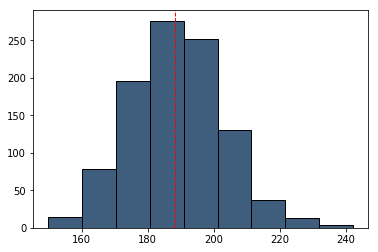

In [9]:
h = plt.hist(simulation, 9,  edgecolor='k', color="#3F5D7D")
l = plt.axvline(num_adjacent_predict, color='r', linestyle='dashed', linewidth=1)


As we can see, the equation well predicts the number of patches of size two due to the spontaneous labelling of neighbouring crypts.


In the calculation performed in the 2014 paper, there was thought to be "too many" singleton crypts and it was hypothesised that there were localized spatial variations in the crypt fission rate. To account for this, the patches of size 1 were excluded from the data. However, on reflection, we believe that the inclusion of the singleton crypts is important as it serves to normalize the number of fission events that have occurred to the number of labelled crypts. We shall now repeat the analysis on the original dataset but including singleton crypts (assuming that each crypt has 4 neighbours).

In [10]:
OriginalData_RevisedCorrections = revised_correction(OriginalData)

OriginalData_RevisedCorrections_fission = calculate_fission_rate(OriginalData_RevisedCorrections)

OriginalData_RevisedCorrections_fission.round(round_dict)

,PatientNumber,FreshFrozen,Disease,Ages,TotalCrypts,1,2,3,4,5,...,8,9,10,11,12,13,14,15,fission_rate,fission_rate_error
0,1,True,Normal,79,4919,287.5,41.3,23,6,3,...,0,0,0,0,0,0,0,0,0.007530,0.000691
1,2,True,Normal,60,3547,57.5,0.0,2,2,0,...,0,0,0,0,0,0,0,0,0.004898,0.001590
2,3,True,Normal,64,6958,90.6,3.7,1,0,0,...,0,0,0,0,0,0,0,0,0.001800,0.000761
3,4,True,FAP,67,6417,123.5,40.2,17,4,7,...,0,0,0,0,0,0,0,0,0.013009,0.001331
4,5,True,FAP,59,4095,46.4,11.8,13,8,8,...,0,0,0,0,0,0,0,0,0.023498,0.002701
5,6,True,FAP,39,3085,30.5,3.3,2,0,0,...,0,0,0,0,0,0,0,0,0.009206,0.003531
6,7,True,AFAP,64,11313,159.8,55.6,17,2,2,...,0,1,0,1,0,0,0,0,0.012925,0.001216
7,8,True,AFAP,65,11755,92.2,35.9,11,4,0,...,0,0,0,0,0,0,0,0,0.011522,0.001485
8,9,True,AFAP,61,4174,79.9,29.5,20,10,1,...,3,0,0,0,0,0,0,0,0.019747,0.001929
9,14,True,Normal,42,2702,21.1,5.5,0,1,0,...,0,0,0,0,0,0,0,0,0.017342,0.005082


In [11]:
# Print the mean fission rate of the original data
print('Original data with the revised correction applied:\n')
print_mean_fission_rate(OriginalData_RevisedCorrections_fission)

Original data with the revised correction applied:

The mean fission rate for Normal is 0.011 ± 0.007
The mean fission rate for FAP is 0.015 ± 0.007
The mean fission rate for AFAP is 0.015 ± 0.004


And finally we apply the appropriate correction to the revised data.

In [12]:
RevisedData_RevisedCorrections = revised_correction(RevisedData)

RevisedData_RevisedCorrections_fission = calculate_fission_rate(RevisedData_RevisedCorrections)

RevisedData_RevisedCorrections_fission.round(round_dict)

,PatientNumber,FreshFrozen,Disease,Ages,TotalCrypts,1,2,3,4,5,...,8,9,10,11,12,13,14,15,fission_rate,fission_rate_error
0,1,True,Normal,79,4919,287.5,41.3,23,6,3,...,0,0,0,0,0,0,0,0,0.007530,0.000691
1,2,True,Normal,60,3547,57.5,0.0,2,2,0,...,0,0,0,0,0,0,0,0,0.004898,0.001590
2,3,True,Normal,64,6958,90.6,3.7,1,0,0,...,0,0,0,0,0,0,0,0,0.001800,0.000761
3,4,True,FAP,67,6417,123.5,40.2,17,4,7,...,0,0,0,0,0,0,0,0,0.013009,0.001331
4,5,True,FAP,59,4095,46.4,11.8,13,8,8,...,0,0,0,0,0,0,0,0,0.023498,0.002701
5,6,True,FAP,39,3085,30.5,3.3,2,0,0,...,0,0,0,0,0,0,0,0,0.009206,0.003531
6,7,True,AFAP,64,11313,159.8,55.6,17,2,2,...,0,1,0,1,0,0,0,0,0.012925,0.001216
7,8,True,AFAP,65,11755,92.2,35.9,11,4,0,...,0,0,0,0,0,0,0,0,0.011522,0.001485
8,9,True,AFAP,61,4174,79.9,29.5,20,10,1,...,3,0,0,0,0,0,0,0,0.019747,0.001929
9,14,True,Normal,42,2702,21.1,5.5,0,1,0,...,0,0,0,0,0,0,0,0,0.017342,0.005082


In [13]:
# Print the mean fission rate of the original data
print('Revised data with the revised correction applied:\n')
print_mean_fission_rate(RevisedData_RevisedCorrections_fission)

Revised data with the revised correction applied:

The mean fission rate for Normal is 0.009 ± 0.005
The mean fission rate for FAP is 0.015 ± 0.007
The mean fission rate for AFAP is 0.015 ± 0.004


Including the singleton crypts yields significantly lower mean fission rates across all three patient cohorts. 

The original correction applied to the data ignores the patches of size 1, so as a consistency check we can compare the number of singleton crypts predicted by the patch size distribution using the fission rates estimated from the model with the actual number of observed singleton crypts.

In [14]:
OriginalFissionRate = RevisedData_OriginalCorrections_fission['fission_rate']
ProbabilityPatchOne = patch_size_distribution(OriginalFissionRate, RevisedData['Ages'], 1)
Number_of_patches = np.sum(RevisedData.loc[:, '1':'15'], 1)
ExpectationPatchOne = ProbabilityPatchOne * Number_of_patches
Fraction_CCO = Number_of_patches/RevisedData['TotalCrypts']
FoldChange =  RevisedData['1'] / ExpectationPatchOne
RevisedData_Expectation = pd.DataFrame({'PatientNumber':RevisedData['PatientNumber'], 'Disease':RevisedData['Disease'],
                                        'FractionCCODeficient':Fraction_CCO, 'ActualPatchOne':RevisedData['1'], 
                                        'ExpectationPatchOne':ExpectationPatchOne, 'FoldChange': FoldChange}, 
                                      columns=['PatientNumber', 'Disease', 'FractionCCODeficient', 'ActualPatchOne', 
                                               'ExpectationPatchOne', 'FoldChange'])

In [15]:
RevisedData_Expectation.round({'FractionCCODeficient':3, 'FoldChange':2}).astype({'ExpectationPatchOne':int})

,PatientNumber,Disease,FractionCCODeficient,ActualPatchOne,ExpectationPatchOne,FoldChange
0,1,Normal,0.068,228,150,1.51
1,2,Normal,0.017,54,24,2.22
2,3,Normal,0.013,86,49,1.74
3,4,FAP,0.029,106,86,1.22
4,5,FAP,0.021,40,35,1.12
5,6,FAP,0.011,29,17,1.63
6,7,AFAP,0.021,143,110,1.29
7,8,AFAP,0.012,86,71,1.20
8,9,AFAP,0.033,65,60,1.07
9,14,Normal,0.010,20,12,1.54


In [16]:
print('The number of crypts of patch size 1 observed/expected is {:.3}'.format(np.sum(RevisedData['1']) / np.sum(ExpectationPatchOne)))

The number of crypts of patch size 1 observed/expected is 1.4


The original approach underestimates the number of singleton crypts in 19/20 samples. Note that, as discussed above, some apparent patches of size 2 are actually two clonally unrelated crypts (i.e. 2 'patches' of size 1), so the observed number of singleton crypts is probably lower than the true number, implying the degree to which the original method underestimates the number of singleton crypts is likely to be even higher than that calculated above.

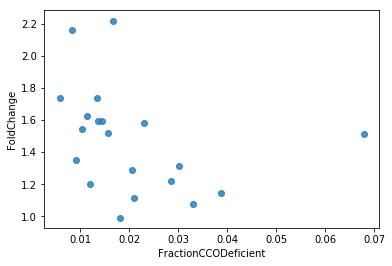

In [17]:
ax = sns.regplot(x='FractionCCODeficient', y='FoldChange', data=RevisedData_Expectation, fit_reg=False)

There appears to be no correlation between the fraction of CCO deficient crypts and the degree to which the original method underestimates the number of singleton crypts.

There was an error in the code used to analyse the data for the paper in which the factor of $(1-p)^{2\zeta - 2}$ was not included. This leads to a slight underestimate of the number of doublet crypts.

In [18]:
total = RevisedData.TotalCrypts
number_of_neighbours = 4
number_of_patches = np.sum(RevisedData.loc[:, '1':'15'], axis = 1)

# Correct the data for spontaneous mutation of adjacent patches
mutation_rate = number_of_patches/total

doublets_original = np.sum(RevisedData_OriginalCorrections['2'])
doublets_revised = np.sum(RevisedData_RevisedCorrections['2'])

print('The number of doublets under the orginal correction - {0:.1f}'.format(doublets_original))
print('The number of doublets under the revised correction - {0:.1f}'.format(doublets_revised))

The number of doublets under the orginal correction - 460.1
The number of doublets under the revised correction - 493.2


However, this has a negligible effect on the calculated fission rates.



If we want to discard the singleton crypts to account for possible spatial heterogeneity, we must renormalize the probability distribution to $m \ge 2$ by doing $K'_m(T) = \frac{K_m(T)}{1-K_1(T)}$. This yields:
$$K'_m(T) = \frac{\left( 1-e^{-\kappa T}\right)^m}{m\left( \kappa T - \left(1 - e^{-\kappa T}\right) \right)}$$

This changes the log-likelihood to:

$$LL' = \sum_{i=1}^{N} m_i \log\left( 1-e^{-\kappa T}\right) - \log(m_i) - \log \left( \kappa T - 1 + e^{-\kappa T}\right)$$

Which is maximised when $\kappa$ satisfies the equation:
$$ \frac{\left(e^{\kappa T} - 1\right)^2}{1 - e^{\kappa T} + \kappa T e^{\kappa T}} -  \frac{1}{N}\sum_{i=1}^{N}m_i =0$$

We shall now perform the above analysis with patches of size $2$ or greater using this approach.


In [19]:
def revised_function_to_solve(b, mean_patch_size, t):
    # This function is a rearranged version of d(LL)/db which will
    # maximise the log-likelihood when set to zero

    func = mean_patch_size - (np.exp(b*t) - 1) ** 2 / (1 - np.exp(b*t) + b*t * np.exp(b*t))

    return func

def revised_wrapper_function(mean_patch_size, t):
    # A wrapper function to pass to fsolve (which can only accept 
    # functions that have a single parameter)

    return lambda b:  revised_function_to_solve(b, mean_patch_size, t)



In [20]:
patch_data = RevisedData_RevisedCorrections.loc[:, '1':'15'].copy()
patch_data['1'] = 0
age = RevisedData_RevisedCorrections.Ages
patch = patch_data.columns.values.astype(int)

b_rate = list()
# b_rate_error = list()
b_initial = 0.01

for index, t in enumerate(age):
    patch_dist = patch_data.loc[index, :]
    mean_patch_size = sum(patch * patch_dist) / sum(patch_dist)

    f_fission = revised_wrapper_function(mean_patch_size, t)

    fission_rate = fsolve(f_fission, b_initial)[0]
#     error = error_on_estimate(fission_rate, t, patch_dist)

    b_rate.append(fission_rate)
#     b_rate_error.append(error)

RevisedData_RevisedCorrections['revised_fission_rate'] = b_rate
# RevisedData_OriginalCorrections['revised_fission_rate_error'] = b_rate_error

disease = ['Normal', 'FAP', 'AFAP']

for d in disease:
    average = np.mean(RevisedData_RevisedCorrections.loc[RevisedData_RevisedCorrections['Disease'] == d, 'revised_fission_rate'])
    sd = np.std(RevisedData_RevisedCorrections.loc[RevisedData_RevisedCorrections['Disease'] == d, 'revised_fission_rate'], ddof=1)
    print('The mean fission rate for {} is {:.2} ± {:.1}'.format(d, average, sd))

The mean fission rate for Normal is 0.012 ± 0.007
The mean fission rate for FAP is 0.015 ± 0.006
The mean fission rate for AFAP is 0.012 ± 0.005


These rates is in-line with the mean fission rates when we include the singleton crypts, suggesting that the inflated fission rate that was calculated in the 2014 paper was an artefact of artificially inflating the mean-patch-size rather than as a consequence of spatial variation. 

In [21]:
RevisedProbabilityPatchOne = patch_size_distribution(RevisedData_RevisedCorrections['revised_fission_rate'], RevisedData['Ages'], 1)
RevisedExpectationPatchOne = RevisedProbabilityPatchOne * Number_of_patches
RevisedFoldChange = RevisedData['1'] / RevisedExpectationPatchOne

Expectation_NewMethod = pd.DataFrame({'PatientNumber':RevisedData['PatientNumber'], 'Disease':RevisedData['Disease'],
                                        'FractionCCODeficient':Fraction_CCO, 'ActualPatchOne':RevisedData['1'], 
                                        'ExpectationPatchOne':RevisedExpectationPatchOne, 'FoldChange': RevisedFoldChange}, 
                                      columns=['PatientNumber', 'Disease', 'FractionCCODeficient', 'ActualPatchOne', 
                                               'ExpectationPatchOne', 'FoldChange'])

Expectation_NewMethod

,PatientNumber,Disease,FractionCCODeficient,ActualPatchOne,ExpectationPatchOne,FoldChange
0,1,Normal,0.067900,228,226.436825,1.006903
1,2,Normal,0.016634,54,32.182292,1.677941
2,3,Normal,0.013366,86,80.772008,1.064725
3,4,FAP,0.028518,106,127.546736,0.831068
4,5,FAP,0.021001,40,47.744652,0.837790
5,6,FAP,0.011345,29,27.757639,1.044757
6,7,AFAP,0.020507,143,162.753836,0.878628
7,8,AFAP,0.011910,86,111.422097,0.771840
8,9,AFAP,0.033062,65,83.828237,0.775395
9,14,Normal,0.010363,20,18.595215,1.075546


In [22]:
print('The number of crypts of patch size 1 observed/expected is {:.3}'.format(np.sum(RevisedData['1']) / np.sum(RevisedExpectationPatchOne)))

The number of crypts of patch size 1 observed/expected is 0.959


This method better predicts the number of singleton crypts than in the 2014 paper in which we did not explicitly take the omission of singleton crypts into the patch size distribution.